<a href="https://colab.research.google.com/github/Altemir1/BTC-ML-Based-Trading-System/blob/main/multi_modal_lstm_btc_direction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset preparation

In [1]:
import pandas as pd

sentiment = pd.read_csv("/content/btc_sentiment_ohlcv (1).csv")
market = pd.read_csv("market_data.csv")

In [2]:
sentiment

,Unnamed: 0,date,negative,neutral,positive,open,high,low,close,volume
0,1155,2017-11-12,4,1,2,6295.450195,6625.049805,5519.009766,5950.069824,8.957350e+09
1,1156,2017-11-13,13,20,12,5938.250000,6811.189941,5844.290039,6559.490234,6.263250e+09
2,1157,2017-11-14,0,5,3,6561.479980,6764.979980,6461.750000,6635.750000,3.197110e+09
3,1158,2017-11-15,6,17,5,6634.759766,7342.250000,6634.759766,7315.540039,4.200880e+09
4,1159,2017-11-16,5,14,4,7323.240234,7967.379883,7176.580078,7871.689941,5.123810e+09
...,...,...,...,...,...,...,...,...,...,...
2102,3257,2023-08-15,6,11,3,29408.048590,29439.120422,29088.853277,29170.347206,1.264020e+10
2103,3258,2023-08-16,7,10,5,29169.074020,29221.975743,28701.779525,28701.779525,1.494927e+10
2104,3259,2023-08-17,8,7,5,28699.802840,28745.946525,25409.111603,26664.549993,3.112085e+10
2105,3260,2023-08-18,19,8,2,26636.078402,26808.195785,25668.922817,26049.556901,2.402624e+10


In [3]:
market

,Unnamed: 0,treasury_yield_10y,gold,sp_500,nasdaq,volatility_index,dollar_index,wti
0,2014-01-02,2.985,1225.000000,1831.979980,4143.069824,14.23,80.629997,95.440002
1,2014-01-03,2.995,1238.400024,1831.369995,4131.910156,13.76,80.790001,93.959999
2,2014-01-04,2.995,1238.400024,1831.369995,4131.910156,13.76,80.790001,93.959999
3,2014-01-05,2.995,1238.400024,1831.369995,4131.910156,13.76,80.790001,93.959999
4,2014-01-06,2.961,1237.800049,1826.770020,4113.680176,13.55,80.650002,93.430000
...,...,...,...,...,...,...,...,...
4012,2024-12-27,4.619,2617.199951,5970.839844,19722.029297,15.95,108.000000,70.599998
4013,2024-12-28,4.619,2617.199951,5970.839844,19722.029297,15.95,108.000000,70.599998
4014,2024-12-29,4.619,2617.199951,5970.839844,19722.029297,15.95,108.000000,70.599998
4015,2024-12-30,4.545,2606.100098,5906.939941,19486.789062,17.40,108.129997,70.989998


In [4]:
# Deletting unececssary columns and set date column as an index
sentiment.drop("Unnamed: 0", axis=1, inplace=True)
sentiment["date"] = pd.to_datetime(sentiment["date"])
sentiment.set_index("date", inplace=True)

market.rename(columns={"Unnamed: 0" : "date"}, inplace=True)
market["date"] = pd.to_datetime(market["date"])
market.set_index("date", inplace=True)

In [5]:
market.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2014-01-02 to 2024-12-31
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   treasury_yield_10y  4017 non-null   float64
 1   gold                4017 non-null   float64
 2   sp_500              4017 non-null   float64
 3   nasdaq              4017 non-null   float64
 4   volatility_index    4017 non-null   float64
 5   dollar_index        4017 non-null   float64
 6   wti                 4017 non-null   float64
dtypes: float64(7)
memory usage: 251.1 KB


In [6]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2107 entries, 2017-11-12 to 2023-08-19
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   negative  2107 non-null   int64  
 1   neutral   2107 non-null   int64  
 2   positive  2107 non-null   int64  
 3   open      2107 non-null   float64
 4   high      2107 non-null   float64
 5   low       2107 non-null   float64
 6   close     2107 non-null   float64
 7   volume    2107 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 148.1 KB


Technical indicators

In [7]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5a7661192a52dbdfbe3b3377e971441b2c99c5667a3ce2a987567314cbb9b756
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [8]:
import pandas as pd
from ta.trend import EMAIndicator, MACD, ADXIndicator, PSARIndicator
from ta.volatility import BollingerBands, AverageTrueRange, KeltnerChannel
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator, AccDistIndexIndicator


def add_technical_indicators(df):
    # Trend Indicators
    df['ema_5'] = EMAIndicator(close=df['close'], window=5).ema_indicator()
    df['ema_20'] = EMAIndicator(close=df['close'], window=20).ema_indicator()
    df['ema_50'] = EMAIndicator(close=df['close'], window=50).ema_indicator()

    macd = MACD(close=df['close'])
    df['macd'] = macd.macd()
    df['signal'] = macd.macd_signal()
    df['histogram'] = macd.macd_diff()

    # Volatility Indicators
    bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_lower'] = bb.bollinger_lband()
    df['bb_middle'] = bb.bollinger_mavg()

    atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['ATR'] = atr.average_true_range()

    # Donchian Channels (manual)
    df['donchian_upper'] = df['high'].rolling(window=20).max()
    df['donchian_lower'] = df['low'].rolling(window=20).min()
    df['donchian_middle'] = (df['donchian_upper'] + df['donchian_lower']) / 2

    # Volume Indicators
    df['obv'] = OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()

    df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()

    return df

In [9]:
df = add_technical_indicators(sentiment)
df.head()

,negative,neutral,positive,open,high,low,close,volume,ema_5,ema_20,...,histogram,bb_upper,bb_lower,bb_middle,ATR,donchian_upper,donchian_lower,donchian_middle,obv,vwap
date,,,,,,,,,,,,,,,,,,,,,
2017-11-12,4,1,2,6295.450195,6625.049805,5519.009766,5950.069824,8.957350e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,8.957350e+09,5950.069824
2017-11-13,13,20,12,5938.250000,6811.189941,5844.290039,6559.490234,6.263250e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.522060e+10,6200.845246
2017-11-14,0,5,3,6561.479980,6764.979980,6461.750000,6635.750000,3.197110e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.841771e+10,6276.339884
2017-11-15,6,17,5,6634.759766,7342.250000,6634.759766,7315.540039,4.200880e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.261859e+10,6469.347286
2017-11-16,5,14,4,7323.240234,7967.379883,7176.580078,7871.689941,5.123810e+09,7055.819607,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.774240e+10,6728.349287


In [10]:
df.dropna(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2058 entries, 2017-12-31 to 2023-08-19
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   negative         2058 non-null   int64  
 1   neutral          2058 non-null   int64  
 2   positive         2058 non-null   int64  
 3   open             2058 non-null   float64
 4   high             2058 non-null   float64
 5   low              2058 non-null   float64
 6   close            2058 non-null   float64
 7   volume           2058 non-null   float64
 8   ema_5            2058 non-null   float64
 9   ema_20           2058 non-null   float64
 10  ema_50           2058 non-null   float64
 11  macd             2058 non-null   float64
 12  signal           2058 non-null   float64
 13  histogram        2058 non-null   float64
 14  bb_upper         2058 non-null   float64
 15  bb_lower         2058 non-null   float64
 16  bb_middle        2058 non-null   float64
 

In [12]:
# Adding days of the week as number
df['day_number'] = df.index.weekday
df["month"] = df.index.month

In [13]:
df = df.join(market, how="left")
df

,negative,neutral,positive,open,high,low,close,volume,ema_5,ema_20,...,obv,vwap,day_number,treasury_yield_10y,gold,sp_500,nasdaq,volatility_index,dollar_index,wti
date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,3,22,6,12897.700195,14377.400391,12755.599609,14156.400391,1.213630e+10,14249.986749,14906.561549,...,5.291101e+10,14279.542564,6,2.405,1306.300049,2673.610107,6903.390137,11.040000,92.120003,60.419998
2018-01-01,4,15,1,14112.200195,14112.200195,13154.700195,13657.200195,1.029120e+10,14052.391231,14787.574753,...,4.261981e+10,14267.278311,0,2.405,1306.300049,2673.610107,6903.390137,11.040000,92.120003,60.419998
2018-01-02,17,48,9,13625.000000,15444.599609,13163.599609,14982.099609,1.684660e+10,14362.294024,14806.100930,...,5.946641e+10,14289.617457,1,2.465,1313.699951,2695.810059,7006.899902,9.770000,91.849998,60.369999
2018-01-03,5,38,13,14978.200195,15572.799805,14844.500000,15201.000000,1.687190e+10,14641.862683,14843.710365,...,7.633831e+10,14317.276505,2,2.447,1316.199951,2713.060059,7065.529785,9.150000,92.160004,61.630001
2018-01-04,23,49,11,15270.700195,15739.700195,14522.200195,15599.200195,2.178320e+10,14960.975187,14915.661778,...,9.812151e+10,14365.611811,3,2.453,1319.400024,2723.989990,7077.910156,9.220000,91.849998,62.009998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-15,6,11,3,29408.048590,29439.120422,29088.853277,29170.347206,1.264020e+10,29312.368589,29395.377865,...,1.027359e+12,27085.362047,1,4.221,1902.500000,4437.859863,13631.049805,16.459999,103.209999,80.989998
2023-08-16,7,10,5,29169.074020,29221.975743,28701.779525,28701.779525,1.494927e+10,29108.838901,29329.320880,...,1.012409e+12,27085.814654,2,4.258,1896.099976,4404.330078,13474.629883,16.780001,103.419998,79.379997
2023-08-17,8,7,5,28699.802840,28745.946525,25409.111603,26664.549993,3.112085e+10,28294.075932,29075.533177,...,9.812885e+11,27085.569239,3,4.308,1884.099976,4370.359863,13316.929688,17.889999,103.440002,80.389999


In [14]:
# Adding target variable
df['target'] = df['close'].diff().apply(lambda x: 1 if x > 0 else 0)
df["target"] = df["target"].shift(-1)

In [15]:
df.dropna(inplace=True)
df

,negative,neutral,positive,open,high,low,close,volume,ema_5,ema_20,...,vwap,day_number,treasury_yield_10y,gold,sp_500,nasdaq,volatility_index,dollar_index,wti,target
date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,3,22,6,12897.700195,14377.400391,12755.599609,14156.400391,1.213630e+10,14249.986749,14906.561549,...,14279.542564,6,2.405,1306.300049,2673.610107,6903.390137,11.040000,92.120003,60.419998,0.0
2018-01-01,4,15,1,14112.200195,14112.200195,13154.700195,13657.200195,1.029120e+10,14052.391231,14787.574753,...,14267.278311,0,2.405,1306.300049,2673.610107,6903.390137,11.040000,92.120003,60.419998,1.0
2018-01-02,17,48,9,13625.000000,15444.599609,13163.599609,14982.099609,1.684660e+10,14362.294024,14806.100930,...,14289.617457,1,2.465,1313.699951,2695.810059,7006.899902,9.770000,91.849998,60.369999,1.0
2018-01-03,5,38,13,14978.200195,15572.799805,14844.500000,15201.000000,1.687190e+10,14641.862683,14843.710365,...,14317.276505,2,2.447,1316.199951,2713.060059,7065.529785,9.150000,92.160004,61.630001,1.0
2018-01-04,23,49,11,15270.700195,15739.700195,14522.200195,15599.200195,2.178320e+10,14960.975187,14915.661778,...,14365.611811,3,2.453,1319.400024,2723.989990,7077.910156,9.220000,91.849998,62.009998,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-14,5,14,6,29283.262943,29660.254339,29124.105547,29408.442550,1.401370e+10,29383.379280,29419.065303,...,27084.868160,0,4.184,1910.599976,4489.720215,13788.330078,14.820000,103.190002,82.510002,0.0
2023-08-15,6,11,3,29408.048590,29439.120422,29088.853277,29170.347206,1.264020e+10,29312.368589,29395.377865,...,27085.362047,1,4.221,1902.500000,4437.859863,13631.049805,16.459999,103.209999,80.989998,0.0
2023-08-16,7,10,5,29169.074020,29221.975743,28701.779525,28701.779525,1.494927e+10,29108.838901,29329.320880,...,27085.814654,2,4.258,1896.099976,4404.330078,13474.629883,16.780001,103.419998,79.379997,0.0


In [16]:
df.describe()

,negative,neutral,positive,open,high,low,close,volume,ema_5,ema_20,...,vwap,day_number,treasury_yield_10y,gold,sp_500,nasdaq,volatility_index,dollar_index,wti,target
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2.057000e+03,2057.000000,2057.000000,...,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,7.817696,19.488576,7.002431,21004.635122,21497.563306,20458.472959,21009.051385,2.573870e+10,20996.169398,20945.309391,...,16849.600796,2.999028,2.246991,1642.772094,3530.906943,10655.247877,20.789106,97.336743,65.942193,0.510938
std,8.084267,14.870419,7.286954,16165.690135,16577.767872,15690.610557,16160.980735,1.906061e+10,16126.069471,16002.161812,...,8305.398139,2.000486,1.003388,255.127906,675.544216,2737.470600,8.000672,5.190883,19.169961,0.500002
min,0.000000,0.000000,0.000000,3236.274773,3275.377827,3191.303562,3236.761645,2.923670e+09,3304.842540,3525.493275,...,7965.222049,0.000000,0.499000,1176.199951,2237.399902,6192.919922,9.150000,88.589996,-37.630001,0.000000
25%,2.000000,8.000000,2.000000,8162.191138,8285.959961,7925.729980,8165.009766,1.272690e+10,8172.917944,8148.371866,...,8760.565102,1.000000,1.489000,1346.599976,2876.320068,7924.160156,15.440000,93.379997,54.700001,0.000000
50%,5.000000,15.000000,4.000000,13952.400391,14511.799805,13580.472071,14133.707153,2.313231e+10,14362.294024,14139.440603,...,12391.796198,3.000000,2.296000,1737.400024,3483.810059,10890.849609,19.100000,96.790001,65.550003,1.000000
75%,11.000000,28.000000,10.000000,30409.561691,30959.965559,29892.226032,30399.066385,3.448336e+10,30388.362742,30515.112803,...,27045.933985,5.000000,2.971000,1847.300049,4137.290039,13119.429688,24.350000,100.040001,76.099998,1.000000
max,94.000000,104.000000,71.000000,67549.735581,68789.625939,66382.061008,67566.830088,3.509679e+11,64988.454794,63208.295961,...,28257.923065,6.000000,4.308000,2051.500000,4796.560059,16057.440430,82.690002,114.110001,123.699997,1.000000


Profiling report for EDA

In [17]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=a9dd02d47eaf6366b2cdad4a95a901e32ac4a88aa4483b9e48be4635b9d725c7
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 32/32 [00:00<00:00, 67.01it/s]
/usr/local/lib/python3.11/dist-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 0 1 ... 3 4 6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


KeyboardInterrupt: 

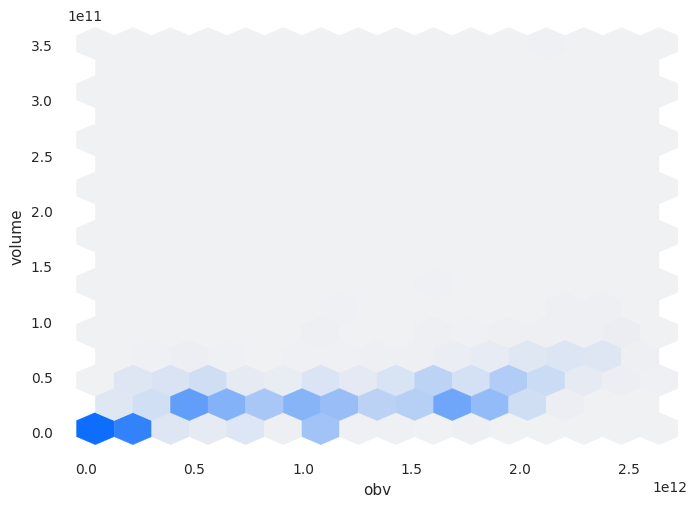

In [18]:
"""from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Mulitmodal dataset for bitcoin direction prediciton", explorative=True)

# Save the report to an HTML file
profile.to_file("multimodal_report.html")
"""

In [ ]:
df.to_csv("multimodal_dataset.csv")

### Scaling and Normalization

**Creating different version of datasets**
- Scaled dataset
- Normalized dataset
- Log transformation dataset
- Log and Normalized dataset

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

target_feature = 'target'  # Replace 'target' with the actual target column name

# Separate features and target
X = df.drop(columns=[target_feature])
y = df[target_feature]

# Initialize StandardScaler and MinMaXScaler
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

features_log = X.copy()
for column in features_log.columns:
    # Applying log transformation. Adjust the shift if necessary.
    features_log[column] = np.log(features_log[column] + 1)

# Log transformed dataset
df_log_transformed = features_log.copy()
df_log_transformed[target_feature] = y

# Log normalized dataset
log_normalized_features = minmax_scaler.fit_transform(features_log)
log_norm_features_df = pd.DataFrame(log_normalized_features, index=features_log.index, columns=features_log.columns)
df_log_norm = log_norm_features_df.copy()
df_log_norm[target_feature] = y

# Fit the scaler to the features and transform them
scaled_features = standard_scaler.fit_transform(X)
normalized_features = minmax_scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
norm_features_df = pd.DataFrame(normalized_features, index=X.index, columns=X.columns)


# Reattach the target feature back to the DataFrame
df_scaled = scaled_features_df.copy()
df_scaled[target_feature] = y

df_norm = norm_features_df.copy()
df_norm[target_feature] = y

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Datasets version collection

In [20]:
dfs = {
    "scaled": df_scaled,
    "normalized": df_norm,
    "log_transformed": df_log_transformed,
    "log_normalized": df_log_norm
}

Saving transformed datasets

In [25]:
for df_name, df in dfs.items():
    df.to_csv(f"{df_name}_dataset.csv", index=False)

### LSTM training and evaluation

Function to create sequence according to the window size

In [21]:
import numpy as np

def create_sequences(data, feature_cols, target_col, window_size=60):
    X, y = [], []

    for i in range(len(data) - window_size):
        # Range of data for this window
        seq_x = data[feature_cols].iloc[i:i+window_size].values
        # Target is the "day after the window"
        seq_y = data[target_col].iloc[i+window_size]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

Function to split data to train and test

In [22]:
def split(df):
  train_size = int(len(df) * 0.8)
  train_data = df[:train_size]
  test_data = df[train_size:]

  return train_data, test_data

Function to create a model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

def create_model(X_train):
  model = Sequential()

  # Model layers
  model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(units=64, return_sequences=True))
  model.add(LSTM(units=32, return_sequences=False))
  model.add(Dense(units=50, activation="relu"))
  model.add(Dense(units=30, activation="relu"))
  model.add(Dense(units=30, activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


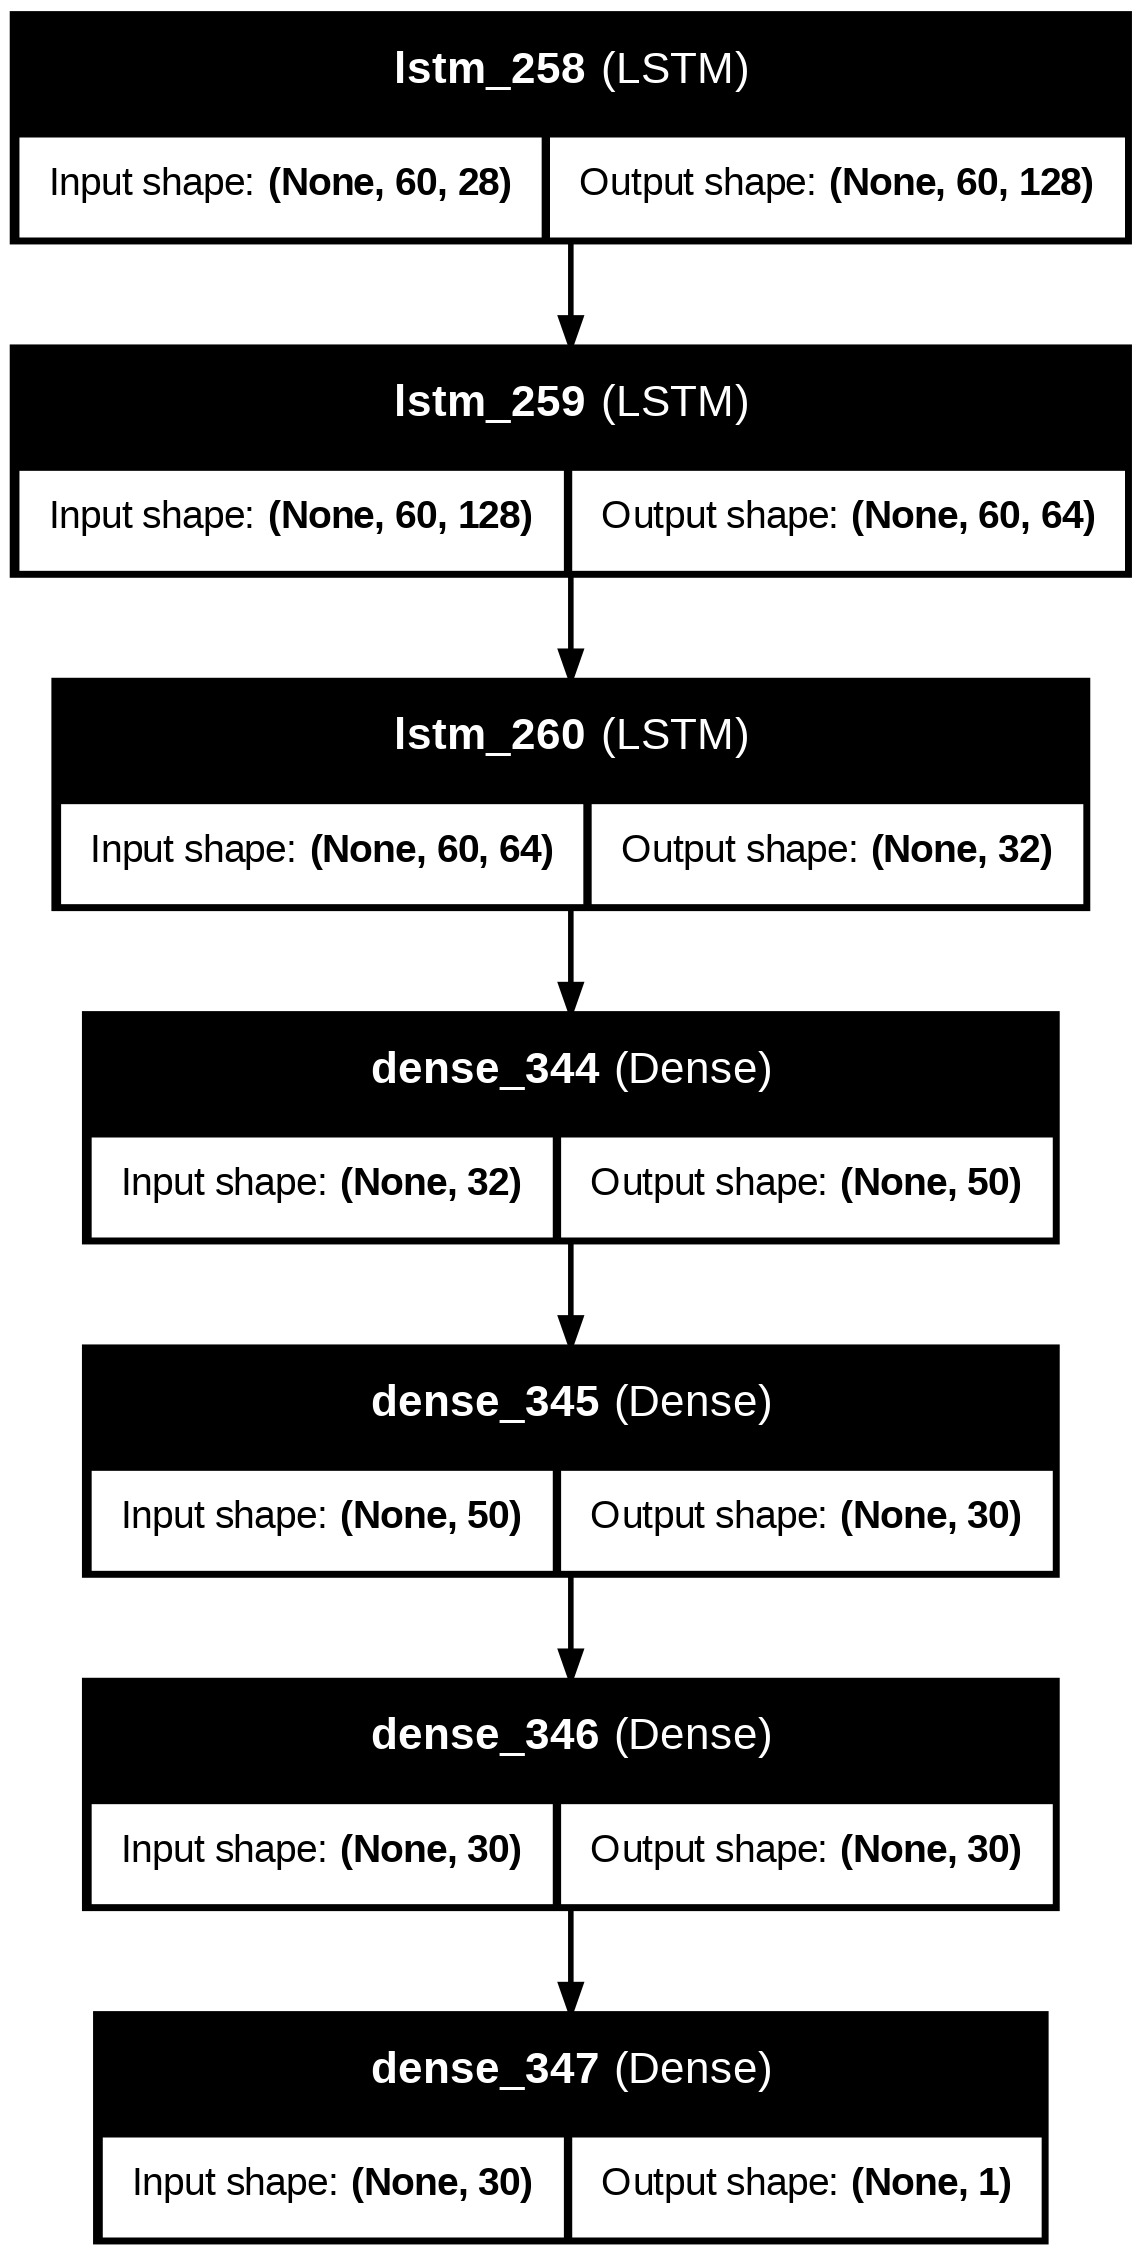

In [52]:
# Plot model to see visual architecture
from tensorflow.keras.utils import plot_model
feature_cols = [col for col in dfs["log_normalized"].columns if col != "target"]
target_col = "target"
X_train = create_sequences(dfs["log_normalized"], feature_cols, target_col, window_size=60)[0]
model = create_model(X_train)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Main training loop

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

def training_loop(df, window_sizes, batch_sizes):

  # Extracting features and target column
  feature_cols = [col for col in df.columns if col != "target"]
  target_col = "target"

  # Creating df to store results for each dataset
  result = pd.DataFrame(columns=["model", "window_size", "batch_size", "train_accuracy", "val_accuracy", "X_test", "y_test"])

  # Split dataframe into train and test
  train_data, test_data = split(df)

  for window_size in window_sizes:
    for batch_size in batch_sizes:

      # Creation of the sequences according to window size
      X_train, y_train = create_sequences(
          data=train_data,
          feature_cols=feature_cols,
          target_col=target_col,
          window_size=window_size
      )
      X_test, y_test = create_sequences(
          data=test_data,
          feature_cols=feature_cols,
          target_col=target_col,
          window_size=window_size
      )

      # Early stopping in case if validation loss doesn't change in 15 epochs
      early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True  # Restore model weights from the best epoch
      )


      # Model creation with different split data
      model = create_model(X_train)

      # Training configuration with different batch sizes
      history = model.fit(
          X_train, y_train,
          epochs=30,
          batch_size=batch_size,
          shuffle=False,
          validation_split=0.1,
          callbacks=[early_stop]
      )

      # Saving results
      train_acc = max(history.history["accuracy"])
      val_acc   = max(history.history["val_accuracy"])

      row_dict = {
              "model": model,
              "window_size": window_size,
              "batch_size": batch_size,
              "train_accuracy": train_acc,
              "val_accuracy": val_acc,
              "X_test" : X_test,
              "y_test" : y_test
          }

      # Creating row dataframe
      temp_df = pd.DataFrame([row_dict])

      # Concatenate with the main results DataFrame
      result = pd.concat([result, temp_df], ignore_index=True)

  return result

In [46]:
# Intial set up
window_sizes = list(range(10, 101, 10))
batch_sizes = [64, 128]

In [30]:
columns_to_drop = ["macd", "signal", "histogram"]
dfs_to_drop = ["log_transformed", "log_normalized"]

for df in dfs_to_drop:
  dfs[df].drop(columns=columns_to_drop, inplace=True)

In [35]:
dfs["log_normalized"].dropna(inplace=True)
dfs["log_transformed"].dropna(inplace=True)

Evalutaion function

In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

def compute_accuracy(model, X_test, y_test):

    # Predicts probability
    y_prob = model.predict(X_test)  # shape: (num_samples, 1)

    # If you need actual class labels (0 or 1):
    y_pred = (y_prob >= 0.5).astype(int)
    # Calculate accuracy
    return accuracy_score(y_test, y_pred)

def compute_best_results(results):

  results["final_accuracy"] = None
  for idx, row in results.iterrows():
      # Grab the trained model from the row
      model = row['model']

      X_test = results["X_test"][idx]
      y_test = results["y_test"][idx]
      # Compute accuracy
      acc = compute_accuracy(model, X_test, y_test)

      # Save to 'final_accuracy' column
      results.at[idx, 'final_accuracy'] = acc

  results_highest = results.sort_values(by="final_accuracy", ascending=False)
  return results_highest.iloc[0]

#### Log transformed data

In [36]:
result_log = training_loop(dfs["log_transformed"], window_sizes, batch_sizes)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4937 - loss: 0.6957 - val_accuracy: 0.4939 - val_loss: 0.6934
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4881 - loss: 0.6960 - val_accuracy: 0.4939 - val_loss: 0.6937
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4869 - loss: 0.6939 - val_accuracy: 0.4939 - val_loss: 0.6958
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5199 - loss: 0.6933 - val_accuracy: 0.4939 - val_loss: 0.6953
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5199 - loss: 0.6929 - val_accuracy: 0.4939 - val_loss: 0.6951
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5199 - loss: 0.6927 - val_accuracy: 0.4939 - val_loss: 0.6952
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5199 - loss: 0.6928 - val_accuracy: 0.4939 - val_loss: 0.6951
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5199 - loss: 0.6927 - val_accuracy: 0.4939 - val_loss: 0.6955


<ipython-input-27-ba779eb1a478>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, temp_df], ignore_index=True)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5006 - loss: 0.6940 - val_accuracy: 0.4939 - val_loss: 0.6959
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5201 - loss: 0.6933 - val_accuracy: 0.4939 - val_loss: 0.6932
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4904 - loss: 0.6947 - val_accuracy: 0.4939 - val_loss: 0.6958
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5201 - loss: 0.6934 - val_accuracy: 0.4939 - val_loss: 0.6963
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5201 - loss: 0.6931 - val_accuracy: 0.4939 - val_loss: 0.6958
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5201 - loss: 0.6929 - val_accuracy: 0.4939 - val_loss: 0.6956
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5201 - loss: 0.6928 - val_accuracy: 0.4939 - val_loss: 0.6955
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5201 - loss: 0.6929 - val_accuracy: 0.4939 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5215 - loss: 0.6939 - val_accuracy: 0.4939 - val_loss: 0.6965
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.4939 - val_loss: 0.6965
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.4939 - val_loss: 0.6951
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4939 - val_loss: 0.6954
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4939 - val_loss: 0.6953
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4939 - val_loss: 0.6952
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4939 - val_loss: 0.6952
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4939 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5224 - loss: 0.6937 - val_accuracy: 0.4939 - val_loss: 0.6956
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5224 - loss: 0.6924 - val_accuracy: 0.4939 - val_loss: 0.6950
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5224 - loss: 0.6923 - val_accuracy: 0.4939 - val_loss: 0.6949
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5224 - loss: 0.6923 - val_accuracy: 0.4939 - val_loss: 0.6949
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5224 - loss: 0.6923 - val_accuracy: 0.4939 - val_loss: 0.6951
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5224 - loss: 0.6923 - val_accuracy: 0.4939 - val_loss: 0.6947
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5224 - loss: 0.6922 - val_accuracy: 0.4939 - val_loss: 0.6946
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5224 - loss: 0.6924 - val_accuracy: 0.4939 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5012 - loss: 0.6946 - val_accuracy: 0.4969 - val_loss: 0.6937
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5169 - loss: 0.6938 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5169 - loss: 0.6935 - val_accuracy: 0.4969 - val_loss: 0.6951
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5169 - loss: 0.6935 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5169 - loss: 0.6933 - val_accuracy: 0.4969 - val_loss: 0.6946
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5169 - loss: 0.6933 - val_accuracy: 0.4969 - val_loss: 0.6946
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5169 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6945
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5169 - loss: 0.6930 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5193 - loss: 0.6951 - val_accuracy: 0.4969 - val_loss: 0.6975
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5193 - loss: 0.6937 - val_accuracy: 0.4969 - val_loss: 0.6954
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5193 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6954
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5193 - loss: 0.6930 - val_accuracy: 0.4969 - val_loss: 0.6950
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5193 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6950
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5193 - loss: 0.6928 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5193 - loss: 0.6928 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5193 - loss: 0.6928 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4957 - loss: 0.6960 - val_accuracy: 0.4969 - val_loss: 0.6977
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5189 - loss: 0.6940 - val_accuracy: 0.4969 - val_loss: 0.6957
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5189 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6954
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5189 - loss: 0.6930 - val_accuracy: 0.4969 - val_loss: 0.6952
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5189 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6950
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5189 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6950
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5189 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6950
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5189 - loss: 0.6928 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.4834 - loss: 0.6961 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5187 - loss: 0.6927 - val_accuracy: 0.4969 - val_loss: 0.6951
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5187 - loss: 0.6928 - val_accuracy: 0.4969 - val_loss: 0.6944
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5187 - loss: 0.6926 - val_accuracy: 0.4969 - val_loss: 0.6939
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5187 - loss: 0.6927 - val_accuracy: 0.4969 - val_loss: 0.6940
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5187 - loss: 0.6925 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5187 - loss: 0.6926 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5187 - loss: 0.6926 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5222 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5093 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5257 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5257 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5257 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5257 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5151 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5261 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5261 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5261 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5261 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5261 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5261 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5261 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4994 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5242 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5242 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5242 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5242 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5242 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5242 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5242 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5061 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5182 - loss: 0.6945 - val_accuracy: 0.4969 - val_loss: 0.6942
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5255 - loss: 0.6934 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5255 - loss: 0.6925 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5255 - loss: 0.6923 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5255 - loss: 0.6923 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5255 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5255 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5255 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5257 - loss: 0.6931 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5257 - loss: 0.6927 - val_accuracy: 0.4969 - val_loss: 0.6944
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5257 - loss: 0.6926 - val_accuracy: 0.4969 - val_loss: 0.6939
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5081 - loss: 0.6935 - val_accuracy: 0.4969 - val_loss: 0.6952
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5257 - loss: 0.6926 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5257 - loss: 0.6923 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6947
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5258 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6950
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5258 - loss: 0.6924 - val_accuracy: 0.4969 - val_loss: 0.6950
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5258 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6953
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5258 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5258 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5258 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5258 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5258 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5245 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6959
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5245 - loss: 0.6924 - val_accuracy: 0.4969 - val_loss: 0.6946
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5245 - loss: 0.6923 - val_accuracy: 0.4969 - val_loss: 0.6945
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5245 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6944
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5245 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6944
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5245 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6944
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5245 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5245 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4918 - loss: 0.6948 - val_accuracy: 0.4938 - val_loss: 0.6937
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4959 - loss: 0.6936 - val_accuracy: 0.4938 - val_loss: 0.6960
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5246 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6954
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5246 - loss: 0.6923 - val_accuracy: 0.4938 - val_loss: 0.6952
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5246 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6956
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5246 - loss: 0.6924 - val_accuracy: 0.4938 - val_loss: 0.6951
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5246 - loss: 0.6923 - val_accuracy: 0.4938 - val_loss: 0.6959
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5246 - loss: 0.6924 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5121 - loss: 0.6948 - val_accuracy: 0.4938 - val_loss: 0.6939
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5249 - loss: 0.6933 - val_accuracy: 0.4938 - val_loss: 0.6966
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5249 - loss: 0.6927 - val_accuracy: 0.4938 - val_loss: 0.6966
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5249 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6959
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5249 - loss: 0.6923 - val_accuracy: 0.4938 - val_loss: 0.6957
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5249 - loss: 0.6923 - val_accuracy: 0.4938 - val_loss: 0.6956
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5249 - loss: 0.6923 - val_accuracy: 0.4938 - val_loss: 0.6953
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5249 - loss: 0.6923 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4909 - loss: 0.6939 - val_accuracy: 0.4938 - val_loss: 0.6976
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5257 - loss: 0.6924 - val_accuracy: 0.4938 - val_loss: 0.6952
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6968
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6951
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5257 - loss: 0.6921 - val_accuracy: 0.4938 - val_loss: 0.6953
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4938 - val_loss: 0.6952
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4938 - val_loss: 0.6951
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5243 - loss: 0.6930 - val_accuracy: 0.4938 - val_loss: 0.6950
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5243 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6951
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5243 - loss: 0.6924 - val_accuracy: 0.4938 - val_loss: 0.6949
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5243 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6947
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5243 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6945
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5243 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6945
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5243 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6946
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5243 - loss: 0.6921 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5012 - loss: 0.6955 - val_accuracy: 0.4906 - val_loss: 0.6956
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5194 - loss: 0.6934 - val_accuracy: 0.4906 - val_loss: 0.6962
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.4906 - val_loss: 0.6959
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5235 - loss: 0.6929 - val_accuracy: 0.4906 - val_loss: 0.6961
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5235 - loss: 0.6926 - val_accuracy: 0.4906 - val_loss: 0.6963
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5235 - loss: 0.6926 - val_accuracy: 0.4906 - val_loss: 0.6961
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5235 - loss: 0.6925 - val_accuracy: 0.4906 - val_loss: 0.6962
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5235 - loss: 0.6925 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4893 - loss: 0.6949 - val_accuracy: 0.4906 - val_loss: 0.6955
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5241 - loss: 0.6932 - val_accuracy: 0.4906 - val_loss: 0.6977
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5241 - loss: 0.6928 - val_accuracy: 0.4906 - val_loss: 0.6966
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5241 - loss: 0.6926 - val_accuracy: 0.4906 - val_loss: 0.6962
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5241 - loss: 0.6924 - val_accuracy: 0.4906 - val_loss: 0.6961
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5241 - loss: 0.6923 - val_accuracy: 0.4906 - val_loss: 0.6954
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5241 - loss: 0.6924 - val_accuracy: 0.4906 - val_loss: 0.6960
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5241 - loss: 0.6923 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5120 - loss: 0.6950 - val_accuracy: 0.4906 - val_loss: 0.6948
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5268 - loss: 0.6921 - val_accuracy: 0.4906 - val_loss: 0.6966
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5268 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6961
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5268 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6959
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5268 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6959
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5268 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6958
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5268 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6958
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5268 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5109 - loss: 0.6941 - val_accuracy: 0.4906 - val_loss: 0.6954
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5263 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6952
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5263 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6959
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5263 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6959
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5263 - loss: 0.6918 - val_accuracy: 0.4906 - val_loss: 0.6953
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5263 - loss: 0.6918 - val_accuracy: 0.4906 - val_loss: 0.6954
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5263 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6956
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5263 - loss: 0.6918 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5245 - loss: 0.6946 - val_accuracy: 0.4937 - val_loss: 0.6949
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5245 - loss: 0.6932 - val_accuracy: 0.4937 - val_loss: 0.6952
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5245 - loss: 0.6927 - val_accuracy: 0.4937 - val_loss: 0.6954
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5245 - loss: 0.6925 - val_accuracy: 0.4937 - val_loss: 0.6953
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5245 - loss: 0.6924 - val_accuracy: 0.4937 - val_loss: 0.6952
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5245 - loss: 0.6924 - val_accuracy: 0.4937 - val_loss: 0.6952
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5245 - loss: 0.6923 - val_accuracy: 0.4937 - val_loss: 0.6952
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5245 - loss: 0.6923 - val_accuracy: 0.4937 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4979 - loss: 0.6944 - val_accuracy: 0.4937 - val_loss: 0.6934
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4955 - loss: 0.6939 - val_accuracy: 0.4937 - val_loss: 0.6946
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5046 - loss: 0.6932 - val_accuracy: 0.4937 - val_loss: 0.6962
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5250 - loss: 0.6923 - val_accuracy: 0.4937 - val_loss: 0.6953
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5250 - loss: 0.6922 - val_accuracy: 0.4937 - val_loss: 0.6952
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5250 - loss: 0.6921 - val_accuracy: 0.4937 - val_loss: 0.6951
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5250 - loss: 0.6921 - val_accuracy: 0.4937 - val_loss: 0.6951
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5250 - loss: 0.6921 - val_accuracy: 0.4937 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4820 - loss: 0.6949 - val_accuracy: 0.4937 - val_loss: 0.6961
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5266 - loss: 0.6922 - val_accuracy: 0.4937 - val_loss: 0.6951
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5266 - loss: 0.6921 - val_accuracy: 0.4937 - val_loss: 0.6952
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4937 - val_loss: 0.6952
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5266 - loss: 0.6921 - val_accuracy: 0.4937 - val_loss: 0.6950
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4937 - val_loss: 0.6949
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4937 - val_loss: 0.6949
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4937 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5265 - loss: 0.6939 - val_accuracy: 0.4937 - val_loss: 0.6941
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4807 - loss: 0.6929 - val_accuracy: 0.4937 - val_loss: 0.6938
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5265 - loss: 0.6924 - val_accuracy: 0.4937 - val_loss: 0.6943
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5265 - loss: 0.6920 - val_accuracy: 0.4937 - val_loss: 0.6943
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5265 - loss: 0.6921 - val_accuracy: 0.4937 - val_loss: 0.6940
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5265 - loss: 0.6922 - val_accuracy: 0.4937 - val_loss: 0.6939
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5265 - loss: 0.6921 - val_accuracy: 0.4937 - val_loss: 0.6940
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5265 - loss: 0.6922 - val_accuracy: 0.4937 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4973 - loss: 0.6969 - val_accuracy: 0.4904 - val_loss: 0.6945
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5215 - loss: 0.6931 - val_accuracy: 0.4904 - val_loss: 0.6957
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.4904 - val_loss: 0.6961
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.4904 - val_loss: 0.6954
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5215 - loss: 0.6927 - val_accuracy: 0.4904 - val_loss: 0.6954
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4904 - val_loss: 0.6955
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4904 - val_loss: 0.6955
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5215 - loss: 0.6925 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4715 - loss: 0.6945 - val_accuracy: 0.4904 - val_loss: 0.6938
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5238 - loss: 0.6935 - val_accuracy: 0.4904 - val_loss: 0.6973
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5238 - loss: 0.6929 - val_accuracy: 0.4904 - val_loss: 0.6968
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5238 - loss: 0.6926 - val_accuracy: 0.4904 - val_loss: 0.6961
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5238 - loss: 0.6924 - val_accuracy: 0.4904 - val_loss: 0.6960
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5238 - loss: 0.6924 - val_accuracy: 0.4904 - val_loss: 0.6954
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5238 - loss: 0.6924 - val_accuracy: 0.4904 - val_loss: 0.6957
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5238 - loss: 0.6923 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4873 - loss: 0.6942 - val_accuracy: 0.4904 - val_loss: 0.6977
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5229 - loss: 0.6928 - val_accuracy: 0.4904 - val_loss: 0.6959
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5229 - loss: 0.6925 - val_accuracy: 0.4904 - val_loss: 0.6958
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5229 - loss: 0.6924 - val_accuracy: 0.4904 - val_loss: 0.6959
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5229 - loss: 0.6924 - val_accuracy: 0.4904 - val_loss: 0.6958
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5229 - loss: 0.6924 - val_accuracy: 0.4904 - val_loss: 0.6958
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.4904 - val_loss: 0.6957
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4911 - loss: 0.6938 - val_accuracy: 0.4904 - val_loss: 0.6983
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5257 - loss: 0.6926 - val_accuracy: 0.4904 - val_loss: 0.6953
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6954
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6957
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6954
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6953
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6953
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5170 - loss: 0.6948 - val_accuracy: 0.4872 - val_loss: 0.6936
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5314 - loss: 0.6940 - val_accuracy: 0.4872 - val_loss: 0.6964
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5314 - loss: 0.6922 - val_accuracy: 0.4872 - val_loss: 0.6955
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5314 - loss: 0.6920 - val_accuracy: 0.4872 - val_loss: 0.6938
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5240 - loss: 0.6929 - val_accuracy: 0.4872 - val_loss: 0.6956
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5314 - loss: 0.6918 - val_accuracy: 0.4872 - val_loss: 0.6961
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5314 - loss: 0.6917 - val_accuracy: 0.4872 - val_loss: 0.6964
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5314 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4837 - loss: 0.6951 - val_accuracy: 0.4872 - val_loss: 0.6971
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5311 - loss: 0.6917 - val_accuracy: 0.4872 - val_loss: 0.6968
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5311 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.6963
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5311 - loss: 0.6918 - val_accuracy: 0.4872 - val_loss: 0.6969
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5311 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.6953
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5311 - loss: 0.6919 - val_accuracy: 0.4872 - val_loss: 0.6968
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5311 - loss: 0.6915 - val_accuracy: 0.4872 - val_loss: 0.6964
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5311 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4944 - loss: 0.6935 - val_accuracy: 0.4872 - val_loss: 0.6968
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5284 - loss: 0.6922 - val_accuracy: 0.4872 - val_loss: 0.6972
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5284 - loss: 0.6921 - val_accuracy: 0.4872 - val_loss: 0.6965
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5284 - loss: 0.6920 - val_accuracy: 0.4872 - val_loss: 0.6967
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5284 - loss: 0.6919 - val_accuracy: 0.4872 - val_loss: 0.6963
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5284 - loss: 0.6919 - val_accuracy: 0.4872 - val_loss: 0.6964
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5284 - loss: 0.6918 - val_accuracy: 0.4872 - val_loss: 0.6964
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5284 - loss: 0.6918 - val_accuracy: 0.4872 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4773 - loss: 0.6941 - val_accuracy: 0.4872 - val_loss: 0.6978
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5288 - loss: 0.6919 - val_accuracy: 0.4872 - val_loss: 0.6964
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5288 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.6955
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5288 - loss: 0.6917 - val_accuracy: 0.4872 - val_loss: 0.6962
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5288 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.6964
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5288 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.6960
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5288 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.6960
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5288 - loss: 0.6916 - val_accuracy: 0.4872 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4859 - loss: 0.6986 - val_accuracy: 0.4839 - val_loss: 0.6946
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5324 - loss: 0.6947 - val_accuracy: 0.4839 - val_loss: 0.6934
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5324 - loss: 0.6944 - val_accuracy: 0.4839 - val_loss: 0.6974
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5324 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6969
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5324 - loss: 0.6916 - val_accuracy: 0.4839 - val_loss: 0.6967
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5324 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6968
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5324 - loss: 0.6914 - val_accuracy: 0.4839 - val_loss: 0.6968
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5324 - loss: 0.6914 - val_accuracy: 0.4839 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.4932 - loss: 0.6970 - val_accuracy: 0.4839 - val_loss: 0.6948
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5305 - loss: 0.6928 - val_accuracy: 0.4839 - val_loss: 0.6972
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5305 - loss: 0.6920 - val_accuracy: 0.4839 - val_loss: 0.6964
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5305 - loss: 0.6924 - val_accuracy: 0.4839 - val_loss: 0.6989
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5305 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6971
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5305 - loss: 0.6916 - val_accuracy: 0.4839 - val_loss: 0.6970
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5305 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6970
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5305 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5138 - loss: 0.6940 - val_accuracy: 0.4839 - val_loss: 0.6967
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5287 - loss: 0.6920 - val_accuracy: 0.4839 - val_loss: 0.6968
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5287 - loss: 0.6918 - val_accuracy: 0.4839 - val_loss: 0.6969
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5287 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6967
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5287 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6967
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5287 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6967
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5287 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6966
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5287 - loss: 0.6917 - val_accuracy: 0.4839 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.4701 - loss: 0.6957 - val_accuracy: 0.5161 - val_loss: 0.6928
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4914 - loss: 0.6934 - val_accuracy: 0.4839 - val_loss: 0.6939
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5299 - loss: 0.6922 - val_accuracy: 0.4839 - val_loss: 0.6952
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5299 - loss: 0.6916 - val_accuracy: 0.4839 - val_loss: 0.6964
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5299 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6969
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5299 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6967
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5299 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6965
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5299 - loss: 0.6914 - val_accuracy: 0.4839 - val_loss: 0.

In [44]:
result_log_test = compute_best_results(result_log)
result_log_test

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━

,39
model,"<Sequential name=sequential_41, built=True>"
window_size,100
batch_size,128
train_accuracy,0.528438
val_accuracy,0.516129
X_test,"[[[2.1972245773362196, 1.3862943611198906, 0.6..."
y_test,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
final_accuracy,0.525641


#### Log transform with normalization

In [47]:
result_log_normalized = training_loop(dfs["log_normalized"], window_sizes, batch_sizes)
result_log_normalized_test = compute_best_results(result_log_normalized)
result_log_normalized_test

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4883 - loss: 0.6937 - val_accuracy: 0.4939 - val_loss: 0.6942
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.4939 - val_loss: 0.6947
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5215 - loss: 0.6924 - val_accuracy: 0.4939 - val_loss: 0.6949
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5215 - loss: 0.6924 - val_accuracy: 0.4939 - val_loss: 0.6933
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5179 - loss: 0.6919 - val_accuracy: 0.4939 - val_loss: 0.6944
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5206 - loss: 0.6915 - val_accuracy: 0.4939 - val_loss: 0.6935
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.6922 - val_accuracy: 0.4939 - val_loss: 0.6938
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5172 - loss: 0.6923 - val_accuracy: 0.4939 - val_loss: 0.

<ipython-input-27-ba779eb1a478>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, temp_df], ignore_index=True)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5216 - loss: 0.6931 - val_accuracy: 0.4939 - val_loss: 0.6953
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5224 - loss: 0.6924 - val_accuracy: 0.4939 - val_loss: 0.6937
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5200 - loss: 0.6919 - val_accuracy: 0.4939 - val_loss: 0.6948
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5223 - loss: 0.6920 - val_accuracy: 0.4878 - val_loss: 0.6931
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5241 - loss: 0.6911 - val_accuracy: 0.5366 - val_loss: 0.6931
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5228 - loss: 0.6913 - val_accuracy: 0.5061 - val_loss: 0.6930
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5390 - loss: 0.6906 - val_accuracy: 0.5122 - val_loss: 0.6927
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5366 - loss: 0.6903 - val_accuracy: 0.4939 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.4869 - loss: 0.6948 - val_accuracy: 0.4969 - val_loss: 0.6938
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5033 - loss: 0.6935 - val_accuracy: 0.4969 - val_loss: 0.6959
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5189 - loss: 0.6931 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5189 - loss: 0.6926 - val_accuracy: 0.4969 - val_loss: 0.6941
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5189 - loss: 0.6925 - val_accuracy: 0.4969 - val_loss: 0.6940
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5189 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5189 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6938
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5189 - loss: 0.6918 - val_accuracy: 0.4969 - val_loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5187 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6957
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5179 - loss: 0.6933 - val_accuracy: 0.4969 - val_loss: 0.6949
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5187 - loss: 0.6927 - val_accuracy: 0.4969 - val_loss: 0.6940
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5159 - loss: 0.6924 - val_accuracy: 0.4969 - val_loss: 0.6932
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5176 - loss: 0.6914 - val_accuracy: 0.4969 - val_loss: 0.6936
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5141 - loss: 0.6917 - val_accuracy: 0.5031 - val_loss: 0.6931
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5124 - loss: 0.6912 - val_accuracy: 0.5031 - val_loss: 0.6931
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5161 - loss: 0.6903 - val_accuracy: 0.5031 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5340 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5242 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5242 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5242 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5242 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5213 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6955
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5242 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5242 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5255 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5255 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5255 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5255 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5255 - loss: 0.6910 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5264 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5255 - loss: 0.6912 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5260 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5258 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6958
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5258 - loss: 0.6922 - val_accuracy: 0.4969 - val_loss: 0.6952
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5258 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6946
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5258 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5258 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.6946
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5258 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.6945
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5258 - loss: 0.6919 - val_accuracy: 0.4969 - val_loss: 0.6941
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5258 - loss: 0.6919 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5286 - loss: 0.6928 - val_accuracy: 0.4969 - val_loss: 0.6933
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5079 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6941
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5245 - loss: 0.6918 - val_accuracy: 0.4969 - val_loss: 0.6947
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5245 - loss: 0.6930 - val_accuracy: 0.4969 - val_loss: 0.6939
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5245 - loss: 0.6918 - val_accuracy: 0.4969 - val_loss: 0.6937
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5245 - loss: 0.6917 - val_accuracy: 0.4969 - val_loss: 0.6935
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5245 - loss: 0.6918 - val_accuracy: 0.4969 - val_loss: 0.6934
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5245 - loss: 0.6914 - val_accuracy: 0.4969 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5110 - loss: 0.6936 - val_accuracy: 0.4938 - val_loss: 0.6949
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5257 - loss: 0.6923 - val_accuracy: 0.4938 - val_loss: 0.6957
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5257 - loss: 0.6921 - val_accuracy: 0.4938 - val_loss: 0.6950
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5257 - loss: 0.6919 - val_accuracy: 0.4938 - val_loss: 0.6951
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5257 - loss: 0.6917 - val_accuracy: 0.4938 - val_loss: 0.6945
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5257 - loss: 0.6904 - val_accuracy: 0.4938 - val_loss: 0.6937
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5168 - loss: 0.6970 - val_accuracy: 0.4938 - val_loss: 0.6936
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5242 - loss: 0.6917 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5243 - loss: 0.6933 - val_accuracy: 0.4938 - val_loss: 0.6952
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5243 - loss: 0.6926 - val_accuracy: 0.4938 - val_loss: 0.6941
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5243 - loss: 0.6919 - val_accuracy: 0.4938 - val_loss: 0.6939
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5178 - loss: 0.6918 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5229 - loss: 0.6912 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5185 - loss: 0.6928 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5243 - loss: 0.6930 - val_accuracy: 0.4938 - val_loss: 0.6940
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5243 - loss: 0.6921 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5170 - loss: 0.6932 - val_accuracy: 0.4906 - val_loss: 0.6952
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5228 - loss: 0.6921 - val_accuracy: 0.4906 - val_loss: 0.6948
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5268 - loss: 0.6922 - val_accuracy: 0.4906 - val_loss: 0.6963
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5268 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6952
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5268 - loss: 0.6918 - val_accuracy: 0.4906 - val_loss: 0.6951
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5268 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6954
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5268 - loss: 0.6914 - val_accuracy: 0.4906 - val_loss: 0.6957
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5268 - loss: 0.6905 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5244 - loss: 0.6930 - val_accuracy: 0.4906 - val_loss: 0.6956
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5263 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6951
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5263 - loss: 0.6916 - val_accuracy: 0.4906 - val_loss: 0.6943
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5273 - loss: 0.6915 - val_accuracy: 0.4906 - val_loss: 0.6935
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5263 - loss: 0.6914 - val_accuracy: 0.5472 - val_loss: 0.6928
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5205 - loss: 0.6917 - val_accuracy: 0.4906 - val_loss: 0.6942
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5234 - loss: 0.6910 - val_accuracy: 0.4906 - val_loss: 0.6942
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5238 - loss: 0.6926 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5069 - loss: 0.6942 - val_accuracy: 0.4937 - val_loss: 0.6949
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5266 - loss: 0.6917 - val_accuracy: 0.4937 - val_loss: 0.6967
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5156 - loss: 0.6919 - val_accuracy: 0.4937 - val_loss: 0.6938
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5216 - loss: 0.6927 - val_accuracy: 0.4937 - val_loss: 0.6938
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5239 - loss: 0.6918 - val_accuracy: 0.4937 - val_loss: 0.6937
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5213 - loss: 0.6913 - val_accuracy: 0.4937 - val_loss: 0.6935
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5266 - loss: 0.6909 - val_accuracy: 0.4937 - val_loss: 0.6937
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5252 - loss: 0.6915 - val_accuracy: 0.5063 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5072 - loss: 0.6933 - val_accuracy: 0.4937 - val_loss: 0.6942
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5119 - loss: 0.6924 - val_accuracy: 0.4937 - val_loss: 0.6935
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5148 - loss: 0.6925 - val_accuracy: 0.5063 - val_loss: 0.6932
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5243 - loss: 0.6917 - val_accuracy: 0.4937 - val_loss: 0.6942
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5257 - loss: 0.6913 - val_accuracy: 0.4684 - val_loss: 0.6938
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5260 - loss: 0.6912 - val_accuracy: 0.5063 - val_loss: 0.6935
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5251 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5175 - loss: 0.6936 - val_accuracy: 0.5063 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4637 - loss: 0.6949 - val_accuracy: 0.4841 - val_loss: 0.6932
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5229 - loss: 0.6931 - val_accuracy: 0.4904 - val_loss: 0.6950
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.4904 - val_loss: 0.6949
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5229 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6951
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5229 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6941
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5059 - loss: 0.6927 - val_accuracy: 0.4904 - val_loss: 0.6951
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5111 - loss: 0.6931 - val_accuracy: 0.4904 - val_loss: 0.7024
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5086 - loss: 0.6935 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5257 - loss: 0.6939 - val_accuracy: 0.4904 - val_loss: 0.6972
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6955
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5257 - loss: 0.6917 - val_accuracy: 0.4904 - val_loss: 0.6951
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5127 - loss: 0.6919 - val_accuracy: 0.5159 - val_loss: 0.6931
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5151 - loss: 0.6914 - val_accuracy: 0.4904 - val_loss: 0.6937
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5257 - loss: 0.6918 - val_accuracy: 0.4904 - val_loss: 0.6940
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.4904 - val_loss: 0.6953
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5257 - loss: 0.6919 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5071 - loss: 0.6938 - val_accuracy: 0.4872 - val_loss: 0.6954
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5284 - loss: 0.6924 - val_accuracy: 0.4872 - val_loss: 0.6959
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5284 - loss: 0.6920 - val_accuracy: 0.4872 - val_loss: 0.6969
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5284 - loss: 0.6921 - val_accuracy: 0.4872 - val_loss: 0.6975
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5284 - loss: 0.6919 - val_accuracy: 0.4872 - val_loss: 0.6957
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5284 - loss: 0.6917 - val_accuracy: 0.4872 - val_loss: 0.6958
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5284 - loss: 0.6917 - val_accuracy: 0.4872 - val_loss: 0.6956
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5284 - loss: 0.6915 - val_accuracy: 0.4872 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.4926 - loss: 0.6932 - val_accuracy: 0.4872 - val_loss: 0.6965
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5288 - loss: 0.6919 - val_accuracy: 0.4872 - val_loss: 0.6953
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5288 - loss: 0.6915 - val_accuracy: 0.4872 - val_loss: 0.6963
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5288 - loss: 0.6914 - val_accuracy: 0.4872 - val_loss: 0.6948
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5274 - loss: 0.6910 - val_accuracy: 0.4872 - val_loss: 0.6943
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5288 - loss: 0.6910 - val_accuracy: 0.4872 - val_loss: 0.6944
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5288 - loss: 0.6908 - val_accuracy: 0.4872 - val_loss: 0.6942
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5278 - loss: 0.6903 - val_accuracy: 0.5321 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.4770 - loss: 0.6952 - val_accuracy: 0.4839 - val_loss: 0.6936
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5287 - loss: 0.6924 - val_accuracy: 0.4839 - val_loss: 0.6951
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5287 - loss: 0.6922 - val_accuracy: 0.4839 - val_loss: 0.6960
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5287 - loss: 0.6919 - val_accuracy: 0.4839 - val_loss: 0.6939
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5304 - loss: 0.6922 - val_accuracy: 0.4839 - val_loss: 0.6949
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5123 - loss: 0.6918 - val_accuracy: 0.4839 - val_loss: 0.6970
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5284 - loss: 0.6928 - val_accuracy: 0.4839 - val_loss: 0.6959
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5287 - loss: 0.6919 - val_accuracy: 0.4839 - val_loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.5299 - loss: 0.6938 - val_accuracy: 0.4839 - val_loss: 0.6979
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5299 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6961
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5299 - loss: 0.6911 - val_accuracy: 0.4839 - val_loss: 0.6973
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5299 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6943
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5299 - loss: 0.6904 - val_accuracy: 0.4839 - val_loss: 0.6942
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5299 - loss: 0.6897 - val_accuracy: 0.4839 - val_loss: 0.6945
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5299 - loss: 0.6920 - val_accuracy: 0.4839 - val_loss: 0.6964
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5299 - loss: 0.6904 - val_accuracy: 0.4839 - val_loss: 0.

,2
model,"<Sequential name=sequential_48, built=True>"
window_size,20
batch_size,64
train_accuracy,0.534565
val_accuracy,0.496933
X_test,"[[[0.4824953835245129, 0.29787412371765665, 0...."
y_test,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
final_accuracy,0.535714


#### Min max normalization

In [48]:
result_normalized = training_loop(dfs["normalized"], window_sizes, batch_sizes)
result_normalized_test = compute_best_results(result_normalized)
result_normalized_test

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.4917 - loss: 0.6932 - val_accuracy: 0.4939 - val_loss: 0.6949
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5211 - loss: 0.6925 - val_accuracy: 0.4939 - val_loss: 0.6951
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5212 - loss: 0.6926 - val_accuracy: 0.4939 - val_loss: 0.6950
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5218 - loss: 0.6926 - val_accuracy: 0.4939 - val_loss: 0.6957
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5211 - loss: 0.6925 - val_accuracy: 0.4939 - val_loss: 0.6947
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5195 - loss: 0.6922 - val_accuracy: 0.4939 - val_loss: 0.6934
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5210 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5213 - loss: 0.6918 - val_accuracy: 0.4939 - val_loss: 0.

<ipython-input-27-ba779eb1a478>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, temp_df], ignore_index=True)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5163 - loss: 0.6928 - val_accuracy: 0.4939 - val_loss: 0.6952
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5220 - loss: 0.6924 - val_accuracy: 0.4939 - val_loss: 0.6942
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5234 - loss: 0.6918 - val_accuracy: 0.4939 - val_loss: 0.6943
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5231 - loss: 0.6920 - val_accuracy: 0.4939 - val_loss: 0.6943
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5243 - loss: 0.6913 - val_accuracy: 0.4268 - val_loss: 0.6942
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5230 - loss: 0.6913 - val_accuracy: 0.5061 - val_loss: 0.6939
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5220 - loss: 0.6910 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5336 - loss: 0.6913 - val_accuracy: 0.4939 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5003 - loss: 0.6941 - val_accuracy: 0.4969 - val_loss: 0.6945
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5184 - loss: 0.6934 - val_accuracy: 0.4969 - val_loss: 0.6963
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5175 - loss: 0.6934 - val_accuracy: 0.4969 - val_loss: 0.6960
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5208 - loss: 0.6928 - val_accuracy: 0.4663 - val_loss: 0.6958
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5183 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6933
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5186 - loss: 0.6926 - val_accuracy: 0.4969 - val_loss: 0.6945
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5195 - loss: 0.6925 - val_accuracy: 0.4969 - val_loss: 0.6944
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5199 - loss: 0.6926 - val_accuracy: 0.5031 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5186 - loss: 0.6930 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5186 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5186 - loss: 0.6925 - val_accuracy: 0.4969 - val_loss: 0.6938
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5151 - loss: 0.6928 - val_accuracy: 0.5031 - val_loss: 0.6933
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5257 - loss: 0.6918 - val_accuracy: 0.5031 - val_loss: 0.6936
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5186 - loss: 0.6925 - val_accuracy: 0.5031 - val_loss: 0.6939
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5183 - loss: 0.6917 - val_accuracy: 0.5031 - val_loss: 0.6934
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5185 - loss: 0.6918 - val_accuracy: 0.5031 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5250 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5093 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5240 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5240 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5240 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5237 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5242 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5246 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5139 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5254 - loss: 0.6922 - val_accuracy: 0.4568 - val_loss: 0.6938
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5066 - loss: 0.6931 - val_accuracy: 0.4506 - val_loss: 0.6938
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5257 - loss: 0.6919 - val_accuracy: 0.4568 - val_loss: 0.6951
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5242 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5267 - loss: 0.6918 - val_accuracy: 0.4568 - val_loss: 0.6969
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5251 - loss: 0.6920 - val_accuracy: 0.4259 - val_loss: 0.6991
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5254 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.4969 - val_loss: 0.6941
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5255 - loss: 0.6924 - val_accuracy: 0.4969 - val_loss: 0.6952
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5255 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5250 - loss: 0.6922 - val_accuracy: 0.4783 - val_loss: 0.6933
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5210 - loss: 0.6925 - val_accuracy: 0.4969 - val_loss: 0.6960
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5255 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6963
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5255 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6961
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5248 - loss: 0.6921 - val_accuracy: 0.4907 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5242 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5137 - loss: 0.6929 - val_accuracy: 0.4969 - val_loss: 0.6940
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5242 - loss: 0.6920 - val_accuracy: 0.4969 - val_loss: 0.6941
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5241 - loss: 0.6921 - val_accuracy: 0.4969 - val_loss: 0.6939
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5254 - loss: 0.6925 - val_accuracy: 0.4969 - val_loss: 0.6940
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5256 - loss: 0.6923 - val_accuracy: 0.4969 - val_loss: 0.6948
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5252 - loss: 0.6924 - val_accuracy: 0.5093 - val_loss: 0.6944
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5221 - loss: 0.6918 - val_accuracy: 0.5031 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4716 - loss: 0.6950 - val_accuracy: 0.4938 - val_loss: 0.6933
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5256 - loss: 0.6928 - val_accuracy: 0.4938 - val_loss: 0.6941
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5256 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6949
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5256 - loss: 0.6920 - val_accuracy: 0.4938 - val_loss: 0.6946
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5256 - loss: 0.6921 - val_accuracy: 0.4938 - val_loss: 0.6954
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5256 - loss: 0.6920 - val_accuracy: 0.4938 - val_loss: 0.6944
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5256 - loss: 0.6919 - val_accuracy: 0.4938 - val_loss: 0.6946
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5256 - loss: 0.6920 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5205 - loss: 0.6931 - val_accuracy: 0.4938 - val_loss: 0.6945
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5136 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6937
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5113 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6933
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5154 - loss: 0.6917 - val_accuracy: 0.4938 - val_loss: 0.6933
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5242 - loss: 0.6913 - val_accuracy: 0.4938 - val_loss: 0.6934
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5242 - loss: 0.6915 - val_accuracy: 0.4938 - val_loss: 0.6936
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5242 - loss: 0.6922 - val_accuracy: 0.4938 - val_loss: 0.6940
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5242 - loss: 0.6921 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5266 - loss: 0.6928 - val_accuracy: 0.4906 - val_loss: 0.6935
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5266 - loss: 0.6924 - val_accuracy: 0.4906 - val_loss: 0.6967
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5266 - loss: 0.6925 - val_accuracy: 0.4906 - val_loss: 0.6958
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6948
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5266 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6952
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6941
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5266 - loss: 0.6918 - val_accuracy: 0.4906 - val_loss: 0.6942
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5261 - loss: 0.6927 - val_accuracy: 0.4906 - val_loss: 0.6953
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5261 - loss: 0.6919 - val_accuracy: 0.4906 - val_loss: 0.6986
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5261 - loss: 0.6923 - val_accuracy: 0.4906 - val_loss: 0.6939
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5261 - loss: 0.6921 - val_accuracy: 0.4906 - val_loss: 0.6968
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5261 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6954
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5279 - loss: 0.6916 - val_accuracy: 0.4906 - val_loss: 0.6946
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5261 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6943
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5274 - loss: 0.6915 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5087 - loss: 0.6934 - val_accuracy: 0.4937 - val_loss: 0.6937
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5052 - loss: 0.6927 - val_accuracy: 0.4937 - val_loss: 0.6953
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5250 - loss: 0.6926 - val_accuracy: 0.4620 - val_loss: 0.6952
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5101 - loss: 0.6940 - val_accuracy: 0.4937 - val_loss: 0.6950
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5263 - loss: 0.6922 - val_accuracy: 0.4937 - val_loss: 0.6966
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5263 - loss: 0.6920 - val_accuracy: 0.4937 - val_loss: 0.6939
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5250 - loss: 0.6919 - val_accuracy: 0.4937 - val_loss: 0.6932
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5215 - loss: 0.6919 - val_accuracy: 0.4937 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4841 - loss: 0.6938 - val_accuracy: 0.4937 - val_loss: 0.6940
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5284 - loss: 0.6922 - val_accuracy: 0.4747 - val_loss: 0.6944
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5243 - loss: 0.6920 - val_accuracy: 0.5063 - val_loss: 0.6933
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5243 - loss: 0.6920 - val_accuracy: 0.4747 - val_loss: 0.6945
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5259 - loss: 0.6921 - val_accuracy: 0.4557 - val_loss: 0.6965
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5288 - loss: 0.6918 - val_accuracy: 0.5127 - val_loss: 0.6972
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5258 - loss: 0.6924 - val_accuracy: 0.5063 - val_loss: 0.6950
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5255 - loss: 0.6918 - val_accuracy: 0.5063 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4897 - loss: 0.6953 - val_accuracy: 0.4904 - val_loss: 0.6950
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5227 - loss: 0.6929 - val_accuracy: 0.4904 - val_loss: 0.6964
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5227 - loss: 0.6931 - val_accuracy: 0.4904 - val_loss: 0.6954
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5231 - loss: 0.6930 - val_accuracy: 0.4777 - val_loss: 0.6969
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5215 - loss: 0.6933 - val_accuracy: 0.4904 - val_loss: 0.6979
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5227 - loss: 0.6933 - val_accuracy: 0.4904 - val_loss: 0.6955
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5228 - loss: 0.6923 - val_accuracy: 0.4650 - val_loss: 0.6943
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5201 - loss: 0.6927 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5255 - loss: 0.6934 - val_accuracy: 0.4904 - val_loss: 0.6966
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5255 - loss: 0.6923 - val_accuracy: 0.4904 - val_loss: 0.6946
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5255 - loss: 0.6921 - val_accuracy: 0.4904 - val_loss: 0.6945
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5255 - loss: 0.6918 - val_accuracy: 0.4968 - val_loss: 0.6932
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5282 - loss: 0.6914 - val_accuracy: 0.4904 - val_loss: 0.6935
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5255 - loss: 0.6914 - val_accuracy: 0.4904 - val_loss: 0.6937
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5255 - loss: 0.6911 - val_accuracy: 0.4904 - val_loss: 0.6937
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5274 - loss: 0.6910 - val_accuracy: 0.4395 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.5181 - loss: 0.6930 - val_accuracy: 0.4872 - val_loss: 0.6967
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5282 - loss: 0.6927 - val_accuracy: 0.4872 - val_loss: 0.6974
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5282 - loss: 0.6926 - val_accuracy: 0.4872 - val_loss: 0.6955
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5290 - loss: 0.6919 - val_accuracy: 0.4872 - val_loss: 0.6976
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5276 - loss: 0.6923 - val_accuracy: 0.4744 - val_loss: 0.6951
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5282 - loss: 0.6920 - val_accuracy: 0.4872 - val_loss: 0.6972
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5275 - loss: 0.6920 - val_accuracy: 0.4615 - val_loss: 0.6947
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5301 - loss: 0.6920 - val_accuracy: 0.4872 - val_loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5287 - loss: 0.6929 - val_accuracy: 0.4872 - val_loss: 0.6955
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5287 - loss: 0.6918 - val_accuracy: 0.4872 - val_loss: 0.6947
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5287 - loss: 0.6915 - val_accuracy: 0.4872 - val_loss: 0.6949
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5290 - loss: 0.6917 - val_accuracy: 0.4872 - val_loss: 0.6947
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5286 - loss: 0.6917 - val_accuracy: 0.4744 - val_loss: 0.6936
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5287 - loss: 0.6915 - val_accuracy: 0.4872 - val_loss: 0.6941
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5283 - loss: 0.6912 - val_accuracy: 0.4808 - val_loss: 0.6932
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5287 - loss: 0.6907 - val_accuracy: 0.4872 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5284 - loss: 0.6934 - val_accuracy: 0.4839 - val_loss: 0.6974
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5284 - loss: 0.6921 - val_accuracy: 0.4839 - val_loss: 0.6956
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5220 - loss: 0.6926 - val_accuracy: 0.4839 - val_loss: 0.6973
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5284 - loss: 0.6923 - val_accuracy: 0.4839 - val_loss: 0.6962
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5284 - loss: 0.6922 - val_accuracy: 0.4839 - val_loss: 0.6978
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5284 - loss: 0.6925 - val_accuracy: 0.4839 - val_loss: 0.6983
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5284 - loss: 0.6922 - val_accuracy: 0.4839 - val_loss: 0.6957
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5284 - loss: 0.6918 - val_accuracy: 0.4839 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4561 - loss: 0.6946 - val_accuracy: 0.4839 - val_loss: 0.6944
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5310 - loss: 0.6921 - val_accuracy: 0.4839 - val_loss: 0.6988
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5296 - loss: 0.6917 - val_accuracy: 0.4839 - val_loss: 0.6959
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5293 - loss: 0.6916 - val_accuracy: 0.4710 - val_loss: 0.6941
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5296 - loss: 0.6913 - val_accuracy: 0.4839 - val_loss: 0.6981
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5314 - loss: 0.6916 - val_accuracy: 0.4839 - val_loss: 0.6974
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5300 - loss: 0.6913 - val_accuracy: 0.4839 - val_loss: 0.6975
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5310 - loss: 0.6912 - val_accuracy: 0.4839 - val_loss: 0.

,3
model,"<Sequential name=sequential_69, built=True>"
window_size,20
batch_size,128
train_accuracy,0.538988
val_accuracy,0.527607
X_test,"[[[0.0851063829787234, 0.028846153846153848, 0..."
y_test,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
final_accuracy,0.535714


#### Standard scaling

In [53]:
result_scaled = training_loop(dfs["scaled"], window_sizes, batch_sizes)
result_scaled_test = compute_best_results(result_scaled)
result_scaled_test

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5224 - loss: 0.6938 - val_accuracy: 0.5366 - val_loss: 0.6928
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5237 - loss: 0.6926 - val_accuracy: 0.4878 - val_loss: 0.6940
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5246 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6976
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5238 - loss: 0.6902 - val_accuracy: 0.5671 - val_loss: 0.6977
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5231 - loss: 0.6902 - val_accuracy: 0.4878 - val_loss: 0.6958
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5403 - loss: 0.6893 - val_accuracy: 0.4939 - val_loss: 0.6986
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5240 - loss: 0.6947 - val_accuracy: 0.4146 - val_loss: 0.6981
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5256 - loss: 0.6895 - val_accuracy: 0.4939 - val_loss: 0.

<ipython-input-27-ba779eb1a478>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, temp_df], ignore_index=True)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5162 - loss: 0.6926 - val_accuracy: 0.5183 - val_loss: 0.6933
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5216 - loss: 0.6916 - val_accuracy: 0.5061 - val_loss: 0.6931
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5230 - loss: 0.6907 - val_accuracy: 0.5305 - val_loss: 0.6943
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5223 - loss: 0.6901 - val_accuracy: 0.4634 - val_loss: 0.6941
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5301 - loss: 0.6894 - val_accuracy: 0.4756 - val_loss: 0.6945
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5466 - loss: 0.6879 - val_accuracy: 0.5305 - val_loss: 0.6951
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5485 - loss: 0.6873 - val_accuracy: 0.5183 - val_loss: 0.6942
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.4634 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5096 - loss: 0.6939 - val_accuracy: 0.5583 - val_loss: 0.6932
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5189 - loss: 0.6936 - val_accuracy: 0.4969 - val_loss: 0.6934
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5196 - loss: 0.6926 - val_accuracy: 0.4908 - val_loss: 0.6932
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5203 - loss: 0.6918 - val_accuracy: 0.5276 - val_loss: 0.6933
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5208 - loss: 0.6911 - val_accuracy: 0.5215 - val_loss: 0.6946
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5188 - loss: 0.6919 - val_accuracy: 0.5031 - val_loss: 0.6945
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5337 - loss: 0.6917 - val_accuracy: 0.5031 - val_loss: 0.6962
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5132 - loss: 0.6942 - val_accuracy: 0.5153 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.4822 - loss: 0.6936 - val_accuracy: 0.5337 - val_loss: 0.6927
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5202 - loss: 0.6924 - val_accuracy: 0.5031 - val_loss: 0.6939
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5218 - loss: 0.6923 - val_accuracy: 0.5031 - val_loss: 0.6936
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5210 - loss: 0.6906 - val_accuracy: 0.5031 - val_loss: 0.6941
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5196 - loss: 0.6914 - val_accuracy: 0.4908 - val_loss: 0.6963
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5294 - loss: 0.6914 - val_accuracy: 0.5031 - val_loss: 0.6946
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5421 - loss: 0.6897 - val_accuracy: 0.5153 - val_loss: 0.6933
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5214 - loss: 0.6947 - val_accuracy: 0.5031 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5118 - loss: 0.6943 - val_accuracy: 0.5123 - val_loss: 0.6938
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5244 - loss: 0.6927 - val_accuracy: 0.4877 - val_loss: 0.6942
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5227 - loss: 0.6920 - val_accuracy: 0.5247 - val_loss: 0.6943
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5242 - loss: 0.6912 - val_accuracy: 0.4568 - val_loss: 0.6939
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5231 - loss: 0.6917 - val_accuracy: 0.5309 - val_loss: 0.6941
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5252 - loss: 0.6920 - val_accuracy: 0.4630 - val_loss: 0.6952
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5250 - loss: 0.6908 - val_accuracy: 0.5000 - val_loss: 0.6964
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5320 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5037 - loss: 0.6934 - val_accuracy: 0.4938 - val_loss: 0.6939
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5267 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6983
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5257 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6982
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5263 - loss: 0.6912 - val_accuracy: 0.5000 - val_loss: 0.6970
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5285 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6975
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5266 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6992
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5254 - loss: 0.6910 - val_accuracy: 0.4938 - val_loss: 0.6943
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5260 - loss: 0.6914 - val_accuracy: 0.5062 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5254 - loss: 0.6935 - val_accuracy: 0.4969 - val_loss: 0.6956
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5228 - loss: 0.6930 - val_accuracy: 0.4969 - val_loss: 0.6929
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5269 - loss: 0.6913 - val_accuracy: 0.4783 - val_loss: 0.6931
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5255 - loss: 0.6939 - val_accuracy: 0.4720 - val_loss: 0.6946
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4869 - loss: 0.6936 - val_accuracy: 0.5155 - val_loss: 0.6939
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5267 - loss: 0.6919 - val_accuracy: 0.4969 - val_loss: 0.6938
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4896 - loss: 0.6945 - val_accuracy: 0.4720 - val_loss: 0.6941
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5270 - loss: 0.6920 - val_accuracy: 0.4720 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.4691 - loss: 0.6960 - val_accuracy: 0.5031 - val_loss: 0.6949
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5105 - loss: 0.6931 - val_accuracy: 0.5031 - val_loss: 0.6948
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5250 - loss: 0.6917 - val_accuracy: 0.5031 - val_loss: 0.6986
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5236 - loss: 0.6913 - val_accuracy: 0.5031 - val_loss: 0.6985
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5242 - loss: 0.6911 - val_accuracy: 0.4596 - val_loss: 0.6940
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5250 - loss: 0.6912 - val_accuracy: 0.4907 - val_loss: 0.6934
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5082 - loss: 0.6926 - val_accuracy: 0.4658 - val_loss: 0.6941
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5241 - loss: 0.6915 - val_accuracy: 0.4845 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4975 - loss: 0.6951 - val_accuracy: 0.5063 - val_loss: 0.6924
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5216 - loss: 0.6927 - val_accuracy: 0.4938 - val_loss: 0.6931
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5234 - loss: 0.6919 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5264 - loss: 0.6927 - val_accuracy: 0.4875 - val_loss: 0.6933
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5069 - loss: 0.6920 - val_accuracy: 0.4875 - val_loss: 0.6937
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5037 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5223 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6937
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5256 - loss: 0.6913 - val_accuracy: 0.4938 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5145 - loss: 0.6932 - val_accuracy: 0.4625 - val_loss: 0.6940
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5228 - loss: 0.6925 - val_accuracy: 0.4938 - val_loss: 0.6942
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5254 - loss: 0.6915 - val_accuracy: 0.4812 - val_loss: 0.6944
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5240 - loss: 0.6908 - val_accuracy: 0.5125 - val_loss: 0.6953
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5468 - loss: 0.6900 - val_accuracy: 0.4938 - val_loss: 0.6949
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5243 - loss: 0.6953 - val_accuracy: 0.5063 - val_loss: 0.6967
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5234 - loss: 0.6914 - val_accuracy: 0.5063 - val_loss: 0.6929
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5249 - loss: 0.6908 - val_accuracy: 0.5063 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5089 - loss: 0.6936 - val_accuracy: 0.4843 - val_loss: 0.6939
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5261 - loss: 0.6926 - val_accuracy: 0.4906 - val_loss: 0.6935
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5273 - loss: 0.6912 - val_accuracy: 0.4906 - val_loss: 0.6957
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5266 - loss: 0.6922 - val_accuracy: 0.4906 - val_loss: 0.6964
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.4906 - val_loss: 0.6939
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5266 - loss: 0.6913 - val_accuracy: 0.4906 - val_loss: 0.6935
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5275 - loss: 0.6914 - val_accuracy: 0.4969 - val_loss: 0.6938
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5266 - loss: 0.6917 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5198 - loss: 0.6937 - val_accuracy: 0.4906 - val_loss: 0.6946
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5261 - loss: 0.6917 - val_accuracy: 0.4906 - val_loss: 0.6939
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5276 - loss: 0.6912 - val_accuracy: 0.4906 - val_loss: 0.6943
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5546 - loss: 0.6906 - val_accuracy: 0.4906 - val_loss: 0.6950
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5400 - loss: 0.6894 - val_accuracy: 0.4843 - val_loss: 0.6958
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5490 - loss: 0.6895 - val_accuracy: 0.4906 - val_loss: 0.6967
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5256 - loss: 0.6944 - val_accuracy: 0.4403 - val_loss: 0.6945
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5270 - loss: 0.6912 - val_accuracy: 0.4906 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5154 - loss: 0.6942 - val_accuracy: 0.4937 - val_loss: 0.6933
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5278 - loss: 0.6929 - val_accuracy: 0.5253 - val_loss: 0.6932
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5271 - loss: 0.6936 - val_accuracy: 0.4684 - val_loss: 0.6945
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5299 - loss: 0.6921 - val_accuracy: 0.4810 - val_loss: 0.6952
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5263 - loss: 0.6915 - val_accuracy: 0.5127 - val_loss: 0.6936
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5270 - loss: 0.6937 - val_accuracy: 0.5063 - val_loss: 0.6945
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5261 - loss: 0.6922 - val_accuracy: 0.5253 - val_loss: 0.6913
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5286 - loss: 0.6911 - val_accuracy: 0.4810 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5112 - loss: 0.6941 - val_accuracy: 0.5190 - val_loss: 0.6941
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5255 - loss: 0.6923 - val_accuracy: 0.5063 - val_loss: 0.6929
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5261 - loss: 0.6913 - val_accuracy: 0.5127 - val_loss: 0.6928
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5278 - loss: 0.6899 - val_accuracy: 0.5063 - val_loss: 0.6937
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5432 - loss: 0.6892 - val_accuracy: 0.5063 - val_loss: 0.6933
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5426 - loss: 0.6890 - val_accuracy: 0.5316 - val_loss: 0.6925
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5129 - loss: 0.6943 - val_accuracy: 0.4810 - val_loss: 0.6952
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5262 - loss: 0.6943 - val_accuracy: 0.4494 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4894 - loss: 0.6947 - val_accuracy: 0.4968 - val_loss: 0.6928
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5236 - loss: 0.6924 - val_accuracy: 0.4904 - val_loss: 0.6938
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5240 - loss: 0.6920 - val_accuracy: 0.4904 - val_loss: 0.6958
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5226 - loss: 0.6918 - val_accuracy: 0.4841 - val_loss: 0.6944
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5159 - loss: 0.6932 - val_accuracy: 0.4904 - val_loss: 0.6955
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5227 - loss: 0.6925 - val_accuracy: 0.4904 - val_loss: 0.6964
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5252 - loss: 0.6922 - val_accuracy: 0.4904 - val_loss: 0.6934
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.4968 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5262 - loss: 0.6932 - val_accuracy: 0.4904 - val_loss: 0.6940
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.4777 - val_loss: 0.6946
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5245 - loss: 0.6910 - val_accuracy: 0.4650 - val_loss: 0.6933
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5279 - loss: 0.6896 - val_accuracy: 0.4904 - val_loss: 0.6950
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5287 - loss: 0.6907 - val_accuracy: 0.4713 - val_loss: 0.6946
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5287 - loss: 0.6910 - val_accuracy: 0.4904 - val_loss: 0.6945
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4849 - loss: 0.6923 - val_accuracy: 0.4904 - val_loss: 0.6955
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5255 - loss: 0.6914 - val_accuracy: 0.4904 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5156 - loss: 0.6949 - val_accuracy: 0.4808 - val_loss: 0.6929
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5282 - loss: 0.6928 - val_accuracy: 0.5256 - val_loss: 0.6931
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5285 - loss: 0.6910 - val_accuracy: 0.5385 - val_loss: 0.6922
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5404 - loss: 0.6907 - val_accuracy: 0.4872 - val_loss: 0.6934
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5288 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5196 - loss: 0.6912 - val_accuracy: 0.4936 - val_loss: 0.6936
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5270 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5292 - loss: 0.6920 - val_accuracy: 0.5128 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4834 - loss: 0.6942 - val_accuracy: 0.4936 - val_loss: 0.6938
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5286 - loss: 0.6921 - val_accuracy: 0.5256 - val_loss: 0.6918
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5278 - loss: 0.6908 - val_accuracy: 0.5256 - val_loss: 0.6928
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5287 - loss: 0.6908 - val_accuracy: 0.4872 - val_loss: 0.6940
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5296 - loss: 0.6917 - val_accuracy: 0.5064 - val_loss: 0.6926
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5287 - loss: 0.6903 - val_accuracy: 0.5064 - val_loss: 0.6934
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5268 - loss: 0.6899 - val_accuracy: 0.5192 - val_loss: 0.6927
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5383 - loss: 0.6897 - val_accuracy: 0.5128 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5116 - loss: 0.6933 - val_accuracy: 0.4839 - val_loss: 0.6934
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5284 - loss: 0.6924 - val_accuracy: 0.4581 - val_loss: 0.6932
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5285 - loss: 0.6943 - val_accuracy: 0.5097 - val_loss: 0.6931
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5289 - loss: 0.6926 - val_accuracy: 0.4581 - val_loss: 0.6931
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5287 - loss: 0.6914 - val_accuracy: 0.5290 - val_loss: 0.6936
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5284 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6940
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5306 - loss: 0.6910 - val_accuracy: 0.5161 - val_loss: 0.6936
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5300 - loss: 0.6903 - val_accuracy: 0.5226 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5084 - loss: 0.6939 - val_accuracy: 0.4903 - val_loss: 0.6930
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5319 - loss: 0.6915 - val_accuracy: 0.4839 - val_loss: 0.6936
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5321 - loss: 0.6910 - val_accuracy: 0.4839 - val_loss: 0.6952
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5296 - loss: 0.6908 - val_accuracy: 0.4839 - val_loss: 0.6983
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5286 - loss: 0.6901 - val_accuracy: 0.5290 - val_loss: 0.6933
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5455 - loss: 0.6891 - val_accuracy: 0.4839 - val_loss: 0.6939
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5337 - loss: 0.6910 - val_accuracy: 0.4968 - val_loss: 0.6962
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5335 - loss: 0.6908 - val_accuracy: 0.4839 - val_loss: 0.

,3
model,"<Sequential name=sequential_91, built=True>"
window_size,20
batch_size,128
train_accuracy,0.566347
val_accuracy,0.533742
X_test,"[[[0.02255599219806541, -1.1090867518093193, -..."
y_test,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
final_accuracy,0.548469


## XGBoost

Model creation and training functiion

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

def xgboost_model_training(df):

  X = df.drop(columns=["target"])
  y = df["target"]

  # Split the data:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

  model = xgb.XGBClassifier(
      objective='binary:logistic',   # Use this objective if you have binary classes (e.g., up/down).
      eval_metric='logloss',         # Evaluation metric can be logloss, error, etc.
      use_label_encoder=False,       # Prevents deprecation warnings in newer versions of XGBoost.
      random_state=42
  )

  # Parameter grid for the grid search
  param_grid = {
      'max_depth': [3, 5, 7],
      'learning_rate': [0.01, 0.1, 0.2],
      'n_estimators': [100, 200, 300],
      'subsample': [0.8, 1.0]
  }

  grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
  grid_search.fit(X_train, y_train)

  # Retrieve the best model after grid search
  best_model = grid_search.best_estimator_
  return best_model, X_test, y_test


Evaluation function

In [55]:
def evaluate_xgboost_model(best_model, X_test, y_test):
  # Make predictions on the test set
  y_pred = best_model.predict(X_test)

  # Evaluate using accuracy and other metrics.
  acc = accuracy_score(y_test, y_pred)
  print("Test Accuracy:", acc)

  # Detailed classification report
  print("Classification Report:\n", classification_report(y_test, y_pred))

  # Confusion matrix to see the distribution of predictions.
  conf_mat = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:\n", conf_mat)

Results

In [56]:
for df_name, df in dfs.items():
  print(f"{df_name}")
  print(50*"-")
  df["month"] = df.index.month
  best_model, X_test, y_test = xgboost_model_training(df)
  evaluate_xgboost_model(best_model, X_test, y_test)
  print(50*"-")
  print()

scaled
--------------------------------------------------
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:41:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5145631067961165
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.92      0.67       220
         1.0       0.36      0.05      0.09       192

    accuracy                           0.51       412
   macro avg       0.44      0.49      0.38       412
weighted avg       0.45      0.51      0.40       412

Confusion Matrix:
 [[202  18]
 [182  10]]
--------------------------------------------------

normalized
--------------------------------------------------
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:44:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5145631067961165
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.90      0.66       220
         1.0       0.39      0.07      0.12       192

    accuracy                           0.51       412
   macro avg       0.46      0.49      0.39       412
weighted avg       0.46      0.51      0.41       412

Confusion Matrix:
 [[198  22]
 [178  14]]
--------------------------------------------------

log_transformed
--------------------------------------------------
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:46:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5194174757281553
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.93      0.67       220
         1.0       0.38      0.05      0.09       192

    accuracy                           0.52       412
   macro avg       0.46      0.49      0.38       412
weighted avg       0.46      0.52      0.40       412

Confusion Matrix:
 [[204  16]
 [182  10]]
--------------------------------------------------

log_normalized
--------------------------------------------------
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:48:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5194174757281553
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.93      0.67       220
         1.0       0.38      0.05      0.09       192

    accuracy                           0.52       412
   macro avg       0.46      0.49      0.38       412
weighted avg       0.46      0.52      0.40       412

Confusion Matrix:
 [[204  16]
 [182  10]]
--------------------------------------------------

